<center><h1>PCA</h1></center>

In this assignment we have to fullfill the following tasks:

Create labeled surrogate data sets. Perform a PCA/Class prediction with ovr logistic regression analysis as developed in the lecture.

**a:** 4 blobs: Create clearly separable 4-blobs in 3d but also a ’disaster’ realization with strong overlaps. Study, show and compare elbow plots and prediction boundaries.

**b:** 2 touching parabola spreads as shown in the lecture, but in 3d (not 2d). Study and show elbow plot and prediction boundaries.

**a,b:** Every plot must be followed by a small take home message.

In [2]:
### imports ###
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [7]:
X, y = make_blobs(n_samples = 250,
                  n_features = 13,
                  centers = 4,
                  cluster_std = 10, # If you alter the variance here, you can make them not clearly separable
                  center_box = (-50, 50))

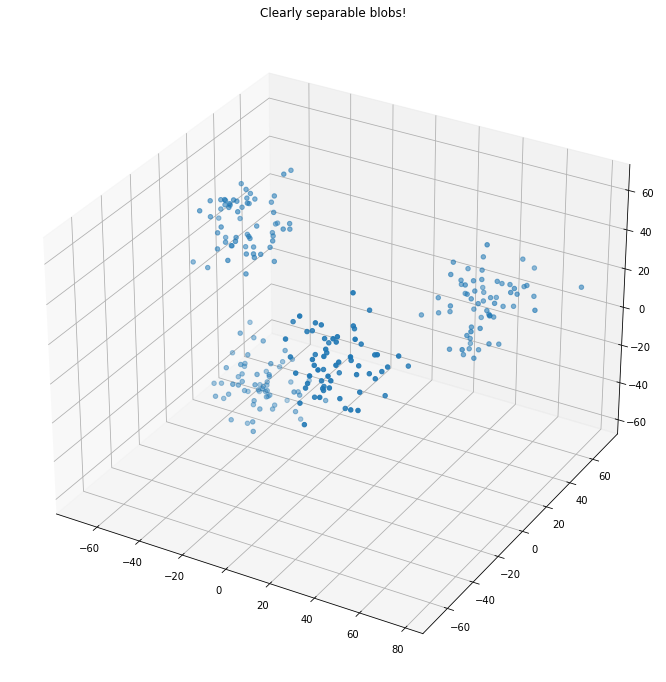

In [8]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(X[:, 0], X[:, 1], X[:, 2])
plt.title("Clearly separable blobs!")
plt.show()

In [9]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

In [10]:
# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
print (X_train.shape)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

(175, 13)


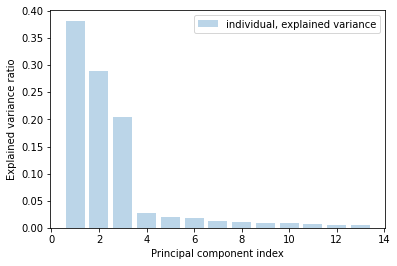

In [11]:
# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Plot explained variances
plt.bar(range(1,14), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [13]:
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(w)
#the above code is equivalent to that one (using reshape)
#w = np.hstack((eigen_pairs[0][1].reshape(13,1), eigen_pairs[1][1].reshape(13,1)))
#print(w)

[[-0.42994398  0.06834819]
 [ 0.09173356  0.47392951]
 [-0.09719547 -0.1649258 ]
 [ 0.27976142 -0.03658371]
 [ 0.05746092  0.48361439]
 [-0.36480026  0.25002728]
 [-0.07998142 -0.15330158]
 [-0.2344977   0.40223359]
 [-0.39753942 -0.13920007]
 [-0.37540526  0.10570229]
 [-0.08836137 -0.32513881]
 [ 0.41536705  0.02206692]
 [ 0.20481289  0.35176537]]


In [14]:
# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)
print (X_train_std.shape, w.shape)

(175, 13) (13, 2)


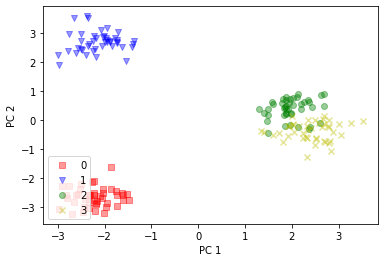

In [15]:
# Visualize the data
colors = ['r', 'b', 'g', 'y']
markers = ['s', 'v', 'o', 'x']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

# Above are the 4 blobs
---
# Now are the parabolas

In [28]:
X, y = make_moons(n_samples = 10000)
X = np.column_stack((X, np.random.choice(X[:,1], len(X)).T))

In [29]:
idx = y == 1

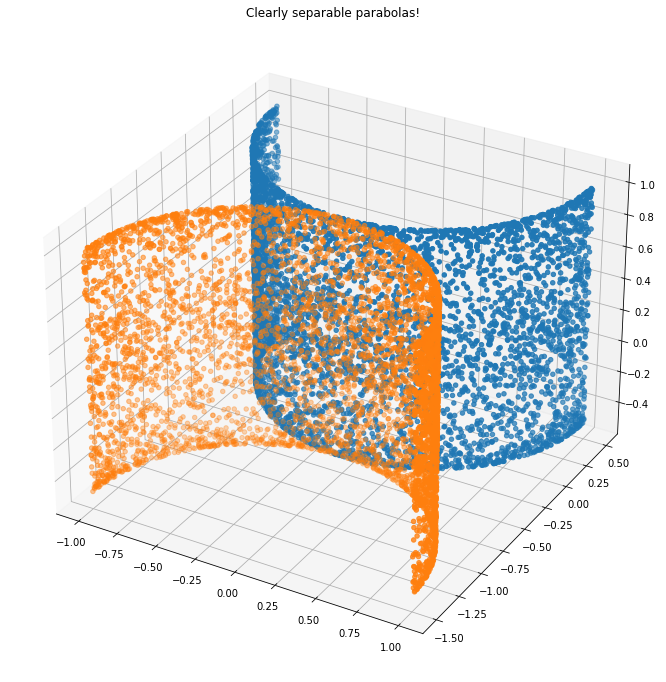

In [30]:
fig = plt.figure(figsize = (12,12))
  
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
ax.scatter3D(X[idx, 0]-1, X[idx, 1], X[idx, 2])
ax.scatter3D(X[~idx, 0], X[~idx, 1]-1.5, X[~idx, 2])
plt.title("Clearly separable parabolas!")
plt.show()

In [18]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0)

# Standardize the features (zero mean, unit variance) 
sc = StandardScaler()

# Fit results must be used later (mu and sigma)
X_train_std = sc.fit_transform(X_train) 

# Normalize test data set with mu/sigma of training data
X_test_std = sc.transform(X_test)

In [19]:
# Compute covariance matrix and eigenvalues (EVal) / eigenvectors (EVec)
print (X_train.shape)
cov_mat = np.cov(X_train_std.T) #cov matrix from data
EVal, EVec = np.linalg.eig(cov_mat)

(3500, 3)


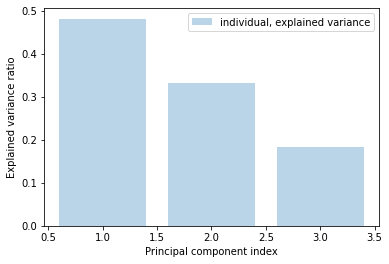

In [20]:
# Calculate (sum of) explained variances
sum_EVal = sum(EVal)
var_exp = [(i / sum_EVal) for i in sorted(EVal, reverse=True)]

# Plot explained variances
plt.bar(range(1,4), var_exp, alpha=0.3, 
        align='center', label='individual, explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [21]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(EVal[i]), EVec[:, i]) for i in range(len(EVal))]

# Sort the (EVal, EVec) tuples from high to low (reverse), key=EV
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [22]:
# Construct matrix w
# stacking, reshaping, adding dim of arrays
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print(w)
#the above code is equivalent to that one (using reshape)
#w = np.hstack((eigen_pairs[0][1].reshape(13,1), eigen_pairs[1][1].reshape(13,1)))
#print(w)

[[ 0.7070633  -0.0019715 ]
 [-0.70578764  0.06008171]
 [ 0.04387826  0.99819152]]


In [23]:
# Transform the entire (training) data to the PCA space, X'=X.W
X_train_pca = X_train_std.dot(w)
print (X_train_std.shape, w.shape)

(3500, 3) (3, 2)


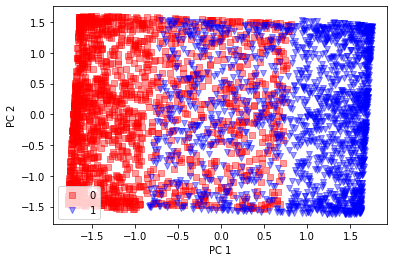

In [24]:
# Visualize the data
colors = ['r', 'b']
markers = ['s', 'v']
#
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train==l, 0], # Pick x component for label
                X_train_pca[y_train==l, 1], 
                color=c, label=l, marker=m, alpha=0.4) 
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()